# ANALYSING THE FEASIBILITY OF A P2P ENERGY TRADING SYSTEM IN STADSHAGEN ZWOLLE

## Data pre-processing 

#### Energy consumption by postcode

In [ ]:
# Energy consumption by postcode (Stadshagen)
import pandas as pd
df = pd.read_csv(r"Publicatiefile_Energie_postcode6_2022_def.csv", delimiter=';')
min_value = 8043
max_value = 8045
df['Postcode6num'] = df['Postcode6'].astype(str).str[:4].astype(int)
filtered_df = df[(df['Postcode6num']>=min_value) & (df['Postcode6num']<=max_value)]
print(filtered_df.head())
filtered_df.to_csv(r"PostcodeEnergyConsumption.csv", index=False, sep=',')

       Postcode6 Gemiddelde_aardgaslevering_woningen  \
398653    8043AA                                 810   
398654    8043AB                                 760   
398655    8043AC                                 550   
398656    8043AD                                 860   
398657    8043AE                                 650   

       Gemiddelde_aardgaslevering_woningen_gecorrigeerd  \
398653                                              930   
398654                                              870   
398655                                              630   
398656                                              980   
398657                                              750   

       Gemiddelde_elektriciteitslevering_woningen  \
398653                                       3290   
398654                                       3210   
398655                                       2040   
398656                                       2140   
398657                                     

#### Adding energy data to postcode

In [ ]:
import geopandas as gpd 
gdf = gpd.read_file(r"PC6bndr.shp")
# Convert shapefile postcodes to string
gdf['Postcode6'] = gdf['PC6'].astype(str)  
 # Convert CSV postcodes to string
df['Postcode6'] = df['Postcode6'].astype(str) 
# gdf.columns
# Merge the CSV data with the shapefile based on 'Postcode'
merged_gdf = gdf.merge(df, on='Postcode6', how='left')

# Check the first few rows
print(merged_gdf.head())
output_path = r'PC6Energy.shp'
merged_gdf.to_file(output_path)


      PC6  Aantal_mul  Aantal_adr     Shape__Are   Shape__Len  \
0  8031ER           2          11  206508.826854  3605.631397   
1  8042PS           2           5  145223.803136  4624.780587   
2  8043AA           1          21    7202.178958   369.539973   
3  8043AB           1          18    7253.629085   360.886204   
4  8043AC           2          24    4711.861055   405.777186   

                                            geometry Postcode6  \
0  POLYGON ((201606.31 505496.311, 201605.947 505...    8031ER   
1  POLYGON ((199377.319 506878.555, 199326.206 50...    8042PS   
2  POLYGON ((201162.773 505503.024, 201142.844 50...    8043AA   
3  POLYGON ((201128.77 505368.283, 201122.023 505...    8043AB   
4  MULTIPOLYGON (((201074.976 505391.505, 201066....    8043AC   

  Gemiddelde_aardgaslevering_woningen  \
0                                1500   
1                                   .   
2                                 810   
3                                 760   
4      

C:\Users\medha\AppData\Local\Temp\ipykernel_20844\4163421204.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_gdf.to_file(output_path)
c:\Users\medha\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Gemiddelde_aardgaslevering_woningen' to 'Gemiddelde'
  ogr_write(
c:\Users\medha\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Gemiddelde_aardgaslevering_woningen_gecorrigeerd' to 'Gemiddel_1'
  ogr_write(
c:\Users\medha\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Gemiddelde_elektriciteitslevering_woningen' to 'Gemiddel_2'
  ogr_write(
c:\Users\medha\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Gemiddel

#### Counting the number of solar panels per post code

In [ ]:
import geopandas as gpd
import pandas as pd
import re

# Load postcode boundary shapefile
postcode_gdf = gpd.read_file(r"PC6Energy.shp")

# Load building shapefile (contains solar panel information)
buildings_gdf = gpd.read_file(r"StadshagenBuildAtr.shp")

# Ensure both datasets have the same CRS
postcode_gdf = postcode_gdf.to_crs(epsg=28992)  
buildings_gdf = buildings_gdf.to_crs(postcode_gdf.crs)

# Function to extract the number of solar panels from text
def extract_panel_count(text):
    match = re.search(r'(\d+)\s*panelen', str(text))  # Extracts the number before "panelen"
    return int(match.group(1)) if match else 0  # Returns extracted number or 0 if not found

# Apply function to extract solar panel count
buildings_gdf["Solar_Count"] = buildings_gdf["ZONNEPANEL"].apply(extract_panel_count)

# Spatial join to assign each building to a postcode
buildings_with_postcode = gpd.sjoin(buildings_gdf, postcode_gdf, how="left", predicate="within")

# Sum solar panels per postcode
solar_panels_per_postcode = buildings_with_postcode.groupby("PC6")["Solar_Count"].sum().reset_index()

# Count the number of buildings per postcode
buildings_count_per_postcode = buildings_with_postcode.groupby("PC6").size().reset_index(name='Building_Count')

# Merge solar panels and building count data with postcode shapefile
postcode_gdf = postcode_gdf.merge(solar_panels_per_postcode, on="PC6", how="left")
postcode_gdf = postcode_gdf.merge(buildings_count_per_postcode, on="PC6", how="left")

# Replace NaN with 0 for solar count and building count
postcode_gdf["Solar_Count"] = postcode_gdf["Solar_Count"].fillna(0).astype(int)
postcode_gdf["Building_Count"] = postcode_gdf["Building_Count"].fillna(0).astype(int)

# Save the updated postcode shapefile
postcode_gdf.to_file(r"postcode_solar_panels_building_count.shp")

print("Solar panel count and building count successfully added to postcode boundaries!")

Solar panel count and building count successfully added to postcode boundaries!


C:\Users\medha\AppData\Local\Temp\ipykernel_20844\3084908539.py:41: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  postcode_gdf.to_file(r"C:\Users\medha\OneDrive - University of Twente\Documents\Q3\Datasets\postcode_solar_panels_building_count.shp")
c:\Users\medha\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Solar_Count' to 'Solar_Coun'
  ogr_write(
c:\Users\medha\AppData\Local\Programs\Python\Python313\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'Building_Count' to 'Building_C'
  ogr_write(


## K-means Clustering to classify postcodes based on consumption and production(PV) capacity 

Index(['PC6', 'Aantal_mul', 'Aantal_adr', 'Shape__Are', 'Shape__Len',
       'Postcode6', 'Gemiddelde', 'Gemiddel_1', 'Gemiddel_2', 'Gemiddel_3',
       'Gemiddel_4', 'Gemiddel_5', 'Postcode6n', 'Solar_Coun', 'Building_C',
       'geometry'],
      dtype='object')


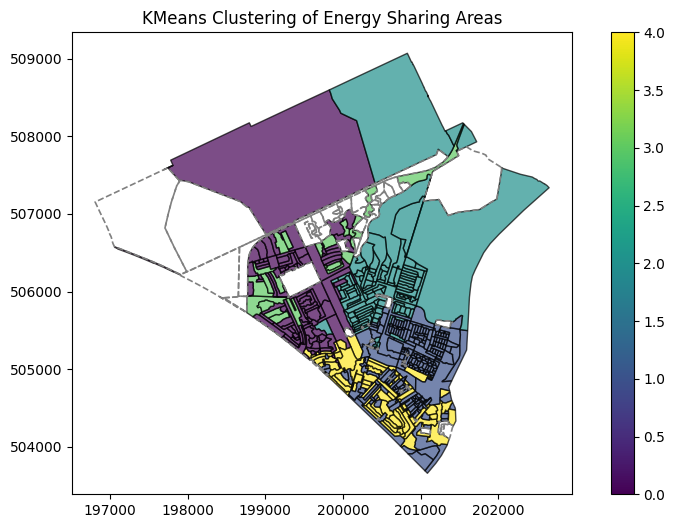

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

## Postcode boundary shapefile
postcodes = gpd.read_file(r"postcode_solar_panels_building_count.shp")

## Clean columns
postcodes.columns = postcodes.columns.str.strip()
print(postcodes.columns)

## Replace non-numeric values with NaN
postcodes['Gemiddel_2'] = pd.to_numeric(postcodes['Gemiddel_2'], errors='coerce')
postcodes['solar_panels'] = pd.to_numeric(postcodes['Solar_Coun'], errors='coerce')

## Data cleaning 
missing_data = postcodes[postcodes['Gemiddel_2'].isna()]
postcodes = postcodes.dropna(subset=['Gemiddel_2'])

## Fill missing values for 'solar_panels' with 0
postcodes['solar_panels'] = postcodes['solar_panels'].fillna(0)
postcodes['TotalEnergy'] = postcodes['Gemiddel_2'] * postcodes['Building_C']

## Convert postcode polygons to centroids
postcodes["centroid"] = postcodes.geometry.centroid
postcodes["x"] = postcodes.centroid.x
postcodes["y"] = postcodes.centroid.y

# Select features for clustering
features = postcodes[['x', 'y', 'TotalEnergy', 'solar_panels']]  # Using 'Gemmidel_2' for energy consumption
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
postcodes["cluster"] = kmeans.fit_predict(scaled_features)

# Plot clusters
fig, ax = plt.subplots(figsize=(10, 6))
postcodes.plot(column="cluster", cmap="viridis", legend=True, ax=ax, alpha=0.7, edgecolor="black")
missing_data.plot(ax=ax, color='none', edgecolor='gray', linestyle='dashed', linewidth=1.2)
plt.title("KMeans Clustering of Energy Sharing Areas")
plt.show()


In [ ]:
# Exporting the clusters as a shapefile 
output_shapefile = r"Clusters.shp"
postcodes['cluster'] = postcodes['cluster'].astype(int)
postcodes_export = postcodes[['geometry', 'cluster']]
postcodes_export.to_file(output_shapefile, driver='ESRI Shapefile')
print("Successfully exported!")

Successfully exported!


#### Cluster definition

In [9]:
# Check the centroids of each cluster
centroids = kmeans.cluster_centers_
print("Cluster Centroids:\n", centroids)

# Check the mean values of features for each cluster
for i in range(n_clusters):
    print(f"Cluster {i} (Class {i+1}) Mean Feature Values:")
    print(postcodes[postcodes["cluster"] == i][['TotalEnergy', 'solar_panels']].mean())

Cluster Centroids:
 [[-1.3578904   0.68261673  0.04978375  0.30499097]
 [ 0.70567985 -0.63071885 -0.55851653 -0.5446942 ]
 [ 0.21680165  0.7458283  -0.09483843 -0.29397045]
 [-1.2388304   1.02424336  2.851891    2.95879669]
 [ 0.29931655 -1.20575604  0.79198895  0.63606872]]
Cluster 0 (Class 1) Mean Feature Values:
TotalEnergy     108057.619048
solar_panels       166.011905
dtype: float64
Cluster 1 (Class 2) Mean Feature Values:
TotalEnergy     54438.972603
solar_panels       43.904110
dtype: float64
Cluster 2 (Class 3) Mean Feature Values:
TotalEnergy     95309.892473
solar_panels       79.935484
dtype: float64
Cluster 3 (Class 4) Mean Feature Values:
TotalEnergy     355049.444444
solar_panels       547.388889
dtype: float64
Cluster 4 (Class 5) Mean Feature Values:
TotalEnergy     173479.318182
solar_panels       213.590909
dtype: float64
